In [502]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 10)

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score, roc_curve, auc
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.compose import ColumnTransformer

import graphviz

## Loading, Merging and Preprocessing Data

In [503]:
file_path = '2023Y_Bank_Regulatory_Financials.xlsx'

In [504]:
# Reading Company_List Tab

df_company = pd.read_excel(file_path, sheet_name='Company_List', header=3, skiprows=range(4, 7))

print(df_company.columns)

df_company.query('`SNL Institution Key ` == 1024885')

Index(['Company Name ', 'SNL Institution Key ', 'City ', 'State ',
       'Regulatory ID ', 'Ownership Structure ', 'Year Established ',
       'De Novo Bank? Yes/No', 'Number of Offices (actual)',
       'Primary Regulator ', 'Public Ownership ',
       'Merger Target or MOE Participant? Yes/No', 'Total Assets ($000)',
       'Asset Growth Rate (%)', 'Loan Growth Rate (%)',
       'Deposit Growth Rate (%)', 'Memo: Full-time Employees (actual)'],
      dtype='object')


,Company Name,SNL Institution Key,City,State,Regulatory ID,Ownership Structure,Year Established,De Novo Bank? Yes/No,Number of Offices (actual),Primary Regulator,Public Ownership,Merger Target or MOE Participant? Yes/No,Total Assets ($000),Asset Growth Rate (%),Loan Growth Rate (%),Deposit Growth Rate (%),Memo: Full-time Employees (actual)
1563,First Community Bank,1024885,Bluefield,VA,2353595.0,Stock Corporation,1920.0,No,58.0,FED,Sub of Major Exchange Instn,No,3241163.0,4.13,7.17,1.53,613.0


In [505]:
# Reading Dupont_Data Tab

df_ratios = pd.read_excel(file_path, sheet_name='Dupont_Data', header=4, skiprows=range(5, 8))

# print(df_ratios.columns)

# Converting NaN values to 0

for column in df_ratios.select_dtypes(include=['object']).columns:
        df_ratios[column] = pd.to_numeric(df_ratios[column], errors='coerce')
        
# Dropping Company Name

df_ratios.drop('Company Name', axis=1, inplace=True)

df_ratios.query('`Institution_Key` == 1024885')



,Institution_Key,ROAE (%),ROAA (%),Avg Assets/ Avg Equity (x),Net Interest Income/ Avg Assets (%),Noninterest Income/ Average Assets (%),Noninterest Expense/ Avg Assets (%),Gain on Securities/ Avg Assets (%),Provision Expense/ Avg Assets (%),Income Tax/ Avg Assets (%),After-tax Items/ Avg Assets (%),Net Interest Margin (%),Avg Earning Assets/ Avg Assets (%),Yield/ Cost Spread (%),Gain on Net Int Position/ Avg EA (%),Yield on Earning Assets (%),Nonint-bear Dep/ Deposits (%),MMDAs+Savings/ Deposits (%),IRA & Keogh Plan/ Deposits (%),Retail Time Dep/ Deposits (%),Jumbo Time Deposits/ Deposits (%),Cost of Interest-bearing Liabilities (%),Net Interest Position/ Avg EA (%),Asset-weighted Loan Yield (%),Asset-weighted Securities Yield (%),Asset-weighted Other Asset Yield (%),Liab-weigh Cost of Int-bear Dep (%),Liability-wtd Borrowing Cost (%),DOM: Construction & Land Development Loans/ Loans (%),DOM: Farm Loans/ Loans (%),DOM: Revolving 1-4 Family Loans/ Loans (%),DOM: Closed-end 1-4 Family Loans/ Loans (%),DOM: Multifamily Loans/ Loans (%),DOM: CommRE(Nfarm/NRes)/ Loans (%),Yield on Loans and Leases (%),Avg Loans/ Avg Earning Assets (%),Yield on Debt and Equity Securities (%),Avg Securities/ Avg Earning Assets (%),Yield on Other Assets (%),Premises & Fixed Assets/ Assets (%),Total Intangible Assets/ Assets (%),Avg Other Assets/ Avg EA (%),Cost of Int-bearing Deposits (%),Avg Int-bear Deps/ Avg Int-bear Liab (%),Cost of Borrowings (%),Avg Borrowing/ Avg Int-bear Liab (%),NII: Fiduciary Activities/ Avg Assets (%),"NII: Inv Bkg, Advsry, &Oth/ Avg Assets (%)",NII: Venture Capital Revenue/ Avg Assets (%),NII: Tot Trading Revenue/ Avg Assets (%),Gain on Asset Sales/ Avg Assets (%),NII: Net Gains Lns & Lses/ Avg Assets (%),NII: Net Gains on OREO/ Avg Assets (%),NII: Net Gns on Oth Assts/ Avg Assets (%),NII: Net Servicing Fees/ Avg Assets (%),NII: Net Securitization Income/ Avg Assets (%),NII: Services Chrgs on Deps/ Avg Assets (%),NII: Ins Commissions & Fees/ Avg Assets (%),NII: Other Insurance Income/ Avg Assets (%),NII: Ins & ReIns Undrwrtg Inc/ Avg Assets (%),NII: Other Noninterest Inc/ Avg Assets (%),Salary Expense/ Avg Assets (%),NIE: Occup & Fixed Asset/ Avg Assets (%),NIE: Amortization of Intang/ Avg Assets (%),Other Noninterest Exp/ Avg Assets (%),Loans/ Deposits (%),Operating Expense/ Operating Revenue (%),Earning Assets/ IBL (%),Brokered Deposits/ Deposits (%),Total: Intangibles/ Equity Capital (%),Equity Capital/ Avg Assets (%)
1563,1024885,11.23,1.48,7.57,3.92,1.22,2.98,0.0,0.26,0.43,0.0,4.4,89.04,4.2,0.2,4.7347,34.05,55.52,0.9204,8.55,0.68,0.53,37.08,4.3903,0.2331,0.1113,0.52,0.01,4.45,0.55,3.41,35.81,7.32,33.94,4.99,87.91,2.3164,10.07,5.51,1.56,4.91,2.02,0.52,99.92,9.76,0.08,0.07,0.06,NaN,NaN,0.02,0.0,0.0,0.02,0.0,NaN,0.43,0.0,NaN,NaN,0.65,1.53,0.34,0.05,1.06,93.98,56.89,159.19,0.13,34.53,14.21


In [506]:
# Reading Deposit_Data Tab

df_deposit = pd.read_excel(file_path, sheet_name='Deposit_Data', header=2, skiprows=range(3, 7))


df_deposit = df_deposit.groupby(by='S&P Institution Key ', as_index=True).agg({'S.O.D. Deposits ($000)': ['sum', 'count']}).reset_index()

df_deposit.columns=['Institution Key', 'TotalBranchDeposits', 'NumberBranches']


df_deposit.query('`Institution Key` == 1024885')

,Institution Key,TotalBranchDeposits,NumberBranches
3578,1024885,2859818.0,58


In [507]:
df = df_company.merge(right=df_ratios, how='left', left_on='SNL Institution Key ', right_on='Institution_Key')
df = df.merge(right=df_deposit, how='left', left_on='SNL Institution Key ', right_on='Institution Key')
df.head(5)

,Company Name,SNL Institution Key,City,State,Regulatory ID,Ownership Structure,Year Established,De Novo Bank? Yes/No,Number of Offices (actual),Primary Regulator,Public Ownership,Merger Target or MOE Participant? Yes/No,Total Assets ($000),Asset Growth Rate (%),Loan Growth Rate (%),Deposit Growth Rate (%),Memo: Full-time Employees (actual),Institution_Key,ROAE (%),ROAA (%),Avg Assets/ Avg Equity (x),Net Interest Income/ Avg Assets (%),Noninterest Income/ Average Assets (%),Noninterest Expense/ Avg Assets (%),Gain on Securities/ Avg Assets (%),Provision Expense/ Avg Assets (%),Income Tax/ Avg Assets (%),After-tax Items/ Avg Assets (%),Net Interest Margin (%),Avg Earning Assets/ Avg Assets (%),Yield/ Cost Spread (%),Gain on Net Int Position/ Avg EA (%),Yield on Earning Assets (%),Nonint-bear Dep/ Deposits (%),MMDAs+Savings/ Deposits (%),IRA & Keogh Plan/ Deposits (%),Retail Time Dep/ Deposits (%),Jumbo Time Deposits/ Deposits (%),Cost of Interest-bearing Liabilities (%),Net Interest Position/ Avg EA (%),Asset-weighted Loan Yield (%),Asset-weighted Securities Yield (%),Asset-weighted Other Asset Yield (%),Liab-weigh Cost of Int-bear Dep (%),Liability-wtd Borrowing Cost (%),DOM: Construction & Land Development Loans/ Loans (%),DOM: Farm Loans/ Loans (%),DOM: Revolving 1-4 Family Loans/ Loans (%),DOM: Closed-end 1-4 Family Loans/ Loans (%),DOM: Multifamily Loans/ Loans (%),DOM: CommRE(Nfarm/NRes)/ Loans (%),Yield on Loans and Leases (%),Avg Loans/ Avg Earning Assets (%),Yield on Debt and Equity Securities (%),Avg Securities/ Avg Earning Assets (%),Yield on Other Assets (%),Premises & Fixed Assets/ Assets (%),Total Intangible Assets/ Assets (%),Avg Other Assets/ Avg EA (%),Cost of Int-bearing Deposits (%),Avg Int-bear Deps/ Avg Int-bear Liab (%),Cost of Borrowings (%),Avg Borrowing/ Avg Int-bear Liab (%),NII: Fiduciary Activities/ Avg Assets (%),"NII: Inv Bkg, Advsry, &Oth/ Avg Assets (%)",NII: Venture Capital Revenue/ Avg Assets (%),NII: Tot Trading Revenue/ Avg Assets (%),Gain on Asset Sales/ Avg Assets (%),NII: Net Gains Lns & Lses/ Avg Assets (%),NII: Net Gains on OREO/ Avg Assets (%),NII: Net Gns on Oth Assts/ Avg Assets (%),NII: Net Servicing Fees/ Avg Assets (%),NII: Net Securitization Income/ Avg Assets (%),NII: Services Chrgs on Deps/ Avg Assets (%),NII: Ins Commissions & Fees/ Avg Assets (%),NII: Other Insurance Income/ Avg Assets (%),NII: Ins & ReIns Undrwrtg Inc/ Avg Assets (%),NII: Other Noninterest Inc/ Avg Assets (%),Salary Expense/ Avg Assets (%),NIE: Occup & Fixed Asset/ Avg Assets (%),NIE: Amortization of Intang/ Avg Assets (%),Other Noninterest Exp/ Avg Assets (%),Loans/ Deposits (%),Operating Expense/ Operating Revenue (%),Earning Assets/ IBL (%),Brokered Deposits/ Deposits (%),Total: Intangibles/ Equity Capital (%),Equity Capital/ Avg Assets (%),Institution Key,TotalBranchDeposits,NumberBranches
0,1NB Bank,1011521,Carlyle,IL,614948.0,Stock Corporation,1878.0,No,4.0,OCC,Private,No,295806.0,3.15,7.69,-6.8,31.0,1011521,7.65,0.50,15.27,2.02,0.31,1.69,0.00,0.06,0.09,0.0,2.18,92.89,1.78,0.40,3.7579,17.56,18.87,0.8236,17.32,9.59,1.98,20.19,2.7589,0.7674,0.2316,1.69,0.29,1.21,32.11,2.14,9.94,1.89,23.83,5.23,52.79,1.8561,41.35,3.95,0.66,0.11,5.86,1.80,94.08,4.90,5.92,0.04,0.01,NaN,NaN,0.01,0.01,0.0,0.0,0.0,NaN,0.08,0.0,NaN,NaN,0.16,0.85,0.16,0.06,0.62,67.58,70.11,122.59,0.0,1.57,7.28,1011521.0,243705.0,4.0
1,1st Advantage Bank,4095211,Saint Peters,MO,3317192.0,Stock Corporation,2005.0,Yes,1.0,FDIC,Private,No,152151.0,0.5,3.43,-0.78,21.0,4095211,11.51,1.18,9.74,3.97,0.18,2.89,0.00,0.09,0.00,0.0,4.04,98.21,3.21,0.83,5.2666,30.28,26.01,1.0362,24.23,13.73,2.06,40.51,4.8092,0.0405,0.4169,1.97,0.09,3.20,1.38,1.15,8.52,3.16,66.25,5.33,90.25,3.6787,1.10,4.82,1.46,0.00,8.65,2.04,96.74,2.61,3.26,0.00,0.00,NaN,NaN,0.00,0.00,0.0,0.0,0.0,NaN,0.06,0.0,NaN,NaN,0.13,1.78,0.24,0.00,0.86,104.57,69.49,157.72,0.0,0.00,10.89,4095211.0,129432.0,1.0
2,1st Bank in Hominy,1008383,Hominy,OK,350657.0,Stock Corporation,1906.0,No,1.0,FED,Private,No,

In [508]:
# Viewing correlated features.

pd.DataFrame(df.corr()['ROAE (%)']).sort_values('ROAE (%)', ascending=False)

,ROAE (%)
ROAE (%),1.000000
Avg Assets/ Avg Equity (x),0.591168
ROAA (%),0.330337
NII: Net Gns on Oth Assts/ Avg Assets (%),0.154372
Gain on Securities/ Avg Assets (%),0.151838
...,...
NIE: Amortization of Intang/ Avg Assets (%),-0.108617
Liab-weigh Cost of Int-bear Dep (%),-0.121182
Cost of Interest-bearing Liabilities (%),-0.136007
Cost of Int-bearing Deposits (%),-0.136879


In [509]:
# Removing rows of data with high threshold of nan values.

threshold = len(df.columns) * 0.50
df['NaN_Count'] = df.isna().sum(axis=1)

df = df[df['NaN_Count'] < threshold]

In [510]:
df.fillna(value=0, inplace=True)

In [511]:
# Creating columns useful for classification
df['Asset_Per_FTE'] = df['Total Assets ($000)'] / (df['Memo: Full-time Employees (actual)'] + 1)
df['AvgBranchDeposits'] = df['TotalBranchDeposits'] / (df['NumberBranches'] + 1)
df['Has_Intangibles'] = df['Total Intangible Assets/ Assets (%)'].apply(lambda x: 1 if x > 0 else 0)

# This will be the initial target variable.

df['ROE_12%'] = df['ROAE (%)'].apply(lambda x: 1 if x >=12 else 0)

In [512]:
df.query('`Institution Key` == 1024885')

,Company Name,SNL Institution Key,City,State,Regulatory ID,Ownership Structure,Year Established,De Novo Bank? Yes/No,Number of Offices (actual),Primary Regulator,Public Ownership,Merger Target or MOE Participant? Yes/No,Total Assets ($000),Asset Growth Rate (%),Loan Growth Rate (%),Deposit Growth Rate (%),Memo: Full-time Employees (actual),Institution_Key,ROAE (%),ROAA (%),Avg Assets/ Avg Equity (x),Net Interest Income/ Avg Assets (%),Noninterest Income/ Average Assets (%),Noninterest Expense/ Avg Assets (%),Gain on Securities/ Avg Assets (%),Provision Expense/ Avg Assets (%),Income Tax/ Avg Assets (%),After-tax Items/ Avg Assets (%),Net Interest Margin (%),Avg Earning Assets/ Avg Assets (%),Yield/ Cost Spread (%),Gain on Net Int Position/ Avg EA (%),Yield on Earning Assets (%),Nonint-bear Dep/ Deposits (%),MMDAs+Savings/ Deposits (%),IRA & Keogh Plan/ Deposits (%),Retail Time Dep/ Deposits (%),Jumbo Time Deposits/ Deposits (%),Cost of Interest-bearing Liabilities (%),Net Interest Position/ Avg EA (%),Asset-weighted Loan Yield (%),Asset-weighted Securities Yield (%),Asset-weighted Other Asset Yield (%),Liab-weigh Cost of Int-bear Dep (%),Liability-wtd Borrowing Cost (%),DOM: Construction & Land Development Loans/ Loans (%),DOM: Farm Loans/ Loans (%),DOM: Revolving 1-4 Family Loans/ Loans (%),DOM: Closed-end 1-4 Family Loans/ Loans (%),DOM: Multifamily Loans/ Loans (%),DOM: CommRE(Nfarm/NRes)/ Loans (%),Yield on Loans and Leases (%),Avg Loans/ Avg Earning Assets (%),Yield on Debt and Equity Securities (%),Avg Securities/ Avg Earning Assets (%),Yield on Other Assets (%),Premises & Fixed Assets/ Assets (%),Total Intangible Assets/ Assets (%),Avg Other Assets/ Avg EA (%),Cost of Int-bearing Deposits (%),Avg Int-bear Deps/ Avg Int-bear Liab (%),Cost of Borrowings (%),Avg Borrowing/ Avg Int-bear Liab (%),NII: Fiduciary Activities/ Avg Assets (%),"NII: Inv Bkg, Advsry, &Oth/ Avg Assets (%)",NII: Venture Capital Revenue/ Avg Assets (%),NII: Tot Trading Revenue/ Avg Assets (%),Gain on Asset Sales/ Avg Assets (%),NII: Net Gains Lns & Lses/ Avg Assets (%),NII: Net Gains on OREO/ Avg Assets (%),NII: Net Gns on Oth Assts/ Avg Assets (%),NII: Net Servicing Fees/ Avg Assets (%),NII: Net Securitization Income/ Avg Assets (%),NII: Services Chrgs on Deps/ Avg Assets (%),NII: Ins Commissions & Fees/ Avg Assets (%),NII: Other Insurance Income/ Avg Assets (%),NII: Ins & ReIns Undrwrtg Inc/ Avg Assets (%),NII: Other Noninterest Inc/ Avg Assets (%),Salary Expense/ Avg Assets (%),NIE: Occup & Fixed Asset/ Avg Assets (%),NIE: Amortization of Intang/ Avg Assets (%),Other Noninterest Exp/ Avg Assets (%),Loans/ Deposits (%),Operating Expense/ Operating Revenue (%),Earning Assets/ IBL (%),Brokered Deposits/ Deposits (%),Total: Intangibles/ Equity Capital (%),Equity Capital/ Avg Assets (%),Institution Key,TotalBranchDeposits,NumberBranches,NaN_Count,Asset_Per_FTE,AvgBranchDeposits,Has_Intangibles,ROE_12%
1563,First Community Bank,1024885,Bluefield,VA,2353595.0,Stock Corporation,1920.0,No,58.0,FED,Sub of Major Exchange Instn,No,3241163.0,4.13,7.17,1.53,613.0,1024885,11.23,1.48,7.57,3.92,1.22,2.98,0.0,0.26,0.43,0.0,4.4,89.04,4.2,0.2,4.7347,34.05,55.52,0.9204,8.55,0.68,0.53,37.08,4.3903,0.2331,0.1113,0.52,0.01,4.45,0.55,3.41,35.81,7.32,33.94,4.99,87.91,2.3164,10.07,5.51,1.56,4.91,2.02,0.52,99.92,9.76,0.08,0.07,0.06,0.0,0.0,0.02,0.0,0.0,0.02,0.0,0.0,0.43,0.0,0.0,0.0,0.65,1.53,0.34,0.05,1.06,93.98,56.89,159.19,0.13,34.53,14.21,1024885.0,2859818.0,58.0,5,5278.767101,48471.491525,1,0


In [513]:
# This is to filter the accounts to do further analysis of FCBC

# df = df.query('`Has_Intangibles` == 1')
# df = df.query('`Total: Intangibles/ Equity Capital (%)` >= 34.53')

drop_cols = ['Institution_Key', 'NaN_Count','Company Name ', 'SNL Institution Key ', 'City ', 'State ',
             'Regulatory ID ', 'Ownership Structure ', 'Year Established ',
#               'Primary Regulator ', 
             'Asset Growth Rate (%)',
             'Loan Growth Rate (%)',
             'Deposit Growth Rate (%)',
             'Public Ownership ',
             'Merger Target or MOE Participant? Yes/No',
             'ROAE (%)', 'ROE_12%', 'ROAA (%)', 'Income Tax/ Avg Assets (%)',
             'Noninterest Expense/ Avg Assets (%)', 'Noninterest Income/ Average Assets (%)',
             'Net Interest Income/ Avg Assets (%)', 'Yield/ Cost Spread (%)',
             'Net Interest Margin (%)', 
             'Institution Key', 'TotalBranchDeposits', 'NumberBranches',
             'Yield on Earning Assets (%)',
             'Operating Expense/ Operating Revenue (%)',
             'Avg Assets/ Avg Equity (x)',
             'Net Interest Position/ Avg EA (%)',
             'Memo: Full-time Employees (actual)',
             'Number of Offices (actual)',
             'Total Assets ($000)'
            ]

X = df.drop(drop_cols, axis=1)

X.replace('NM', 0, inplace=True)

y = df['ROE_12%']

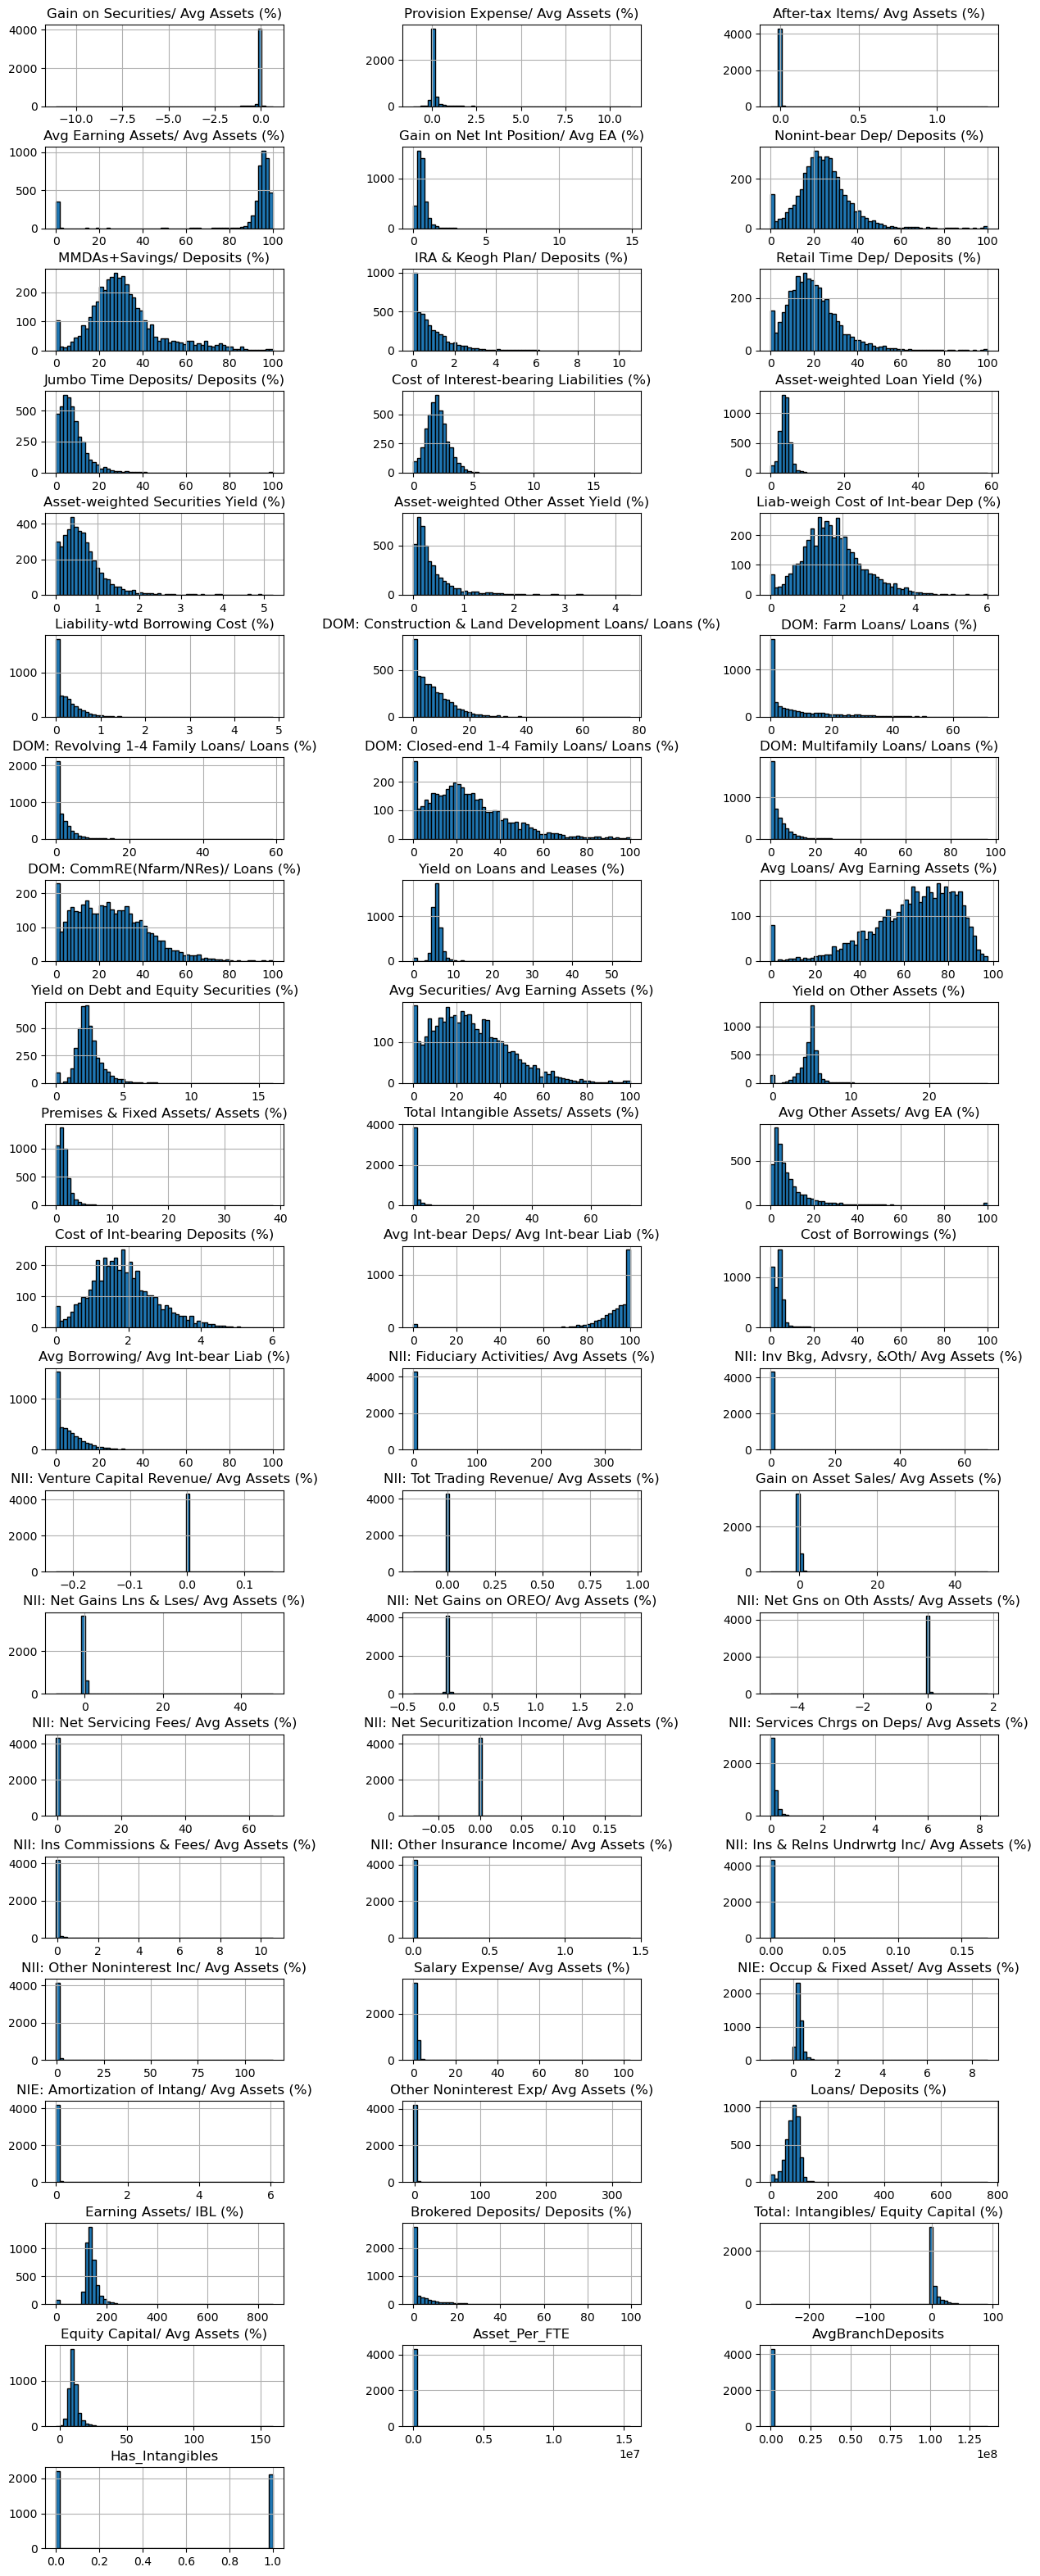

In [514]:
X.hist(figsize=(15, 40), bins=60, layout=(-1, 3), edgecolor='black')
plt.subplots_adjust(hspace=.5, wspace=.5)
plt.show()

## Perform OneHotEncoding on Labels

In [515]:
# Perform OnehotEncoding on object columns

cat_cols = X.select_dtypes(include=['object']).columns.tolist()

# cat_cols

col_transformer = OneHotEncoder(handle_unknown='ignore')

preprocessed = ColumnTransformer(
                                  transformers=[('cat', col_transformer, cat_cols)], remainder='passthrough'      
                                )

X_transformed = preprocessed.fit_transform(X)

X_transformed = pd.DataFrame(X_transformed, columns=preprocessed.get_feature_names_out())

# Optionally, you can display the DataFrame to verify its structure
X_transformed.head()

,cat__De Novo Bank? Yes/No_No,cat__De Novo Bank? Yes/No_Yes,cat__Primary Regulator _FDIC,cat__Primary Regulator _FED,cat__Primary Regulator _OCC,remainder__Gain on Securities/ Avg Assets (%),remainder__Provision Expense/ Avg Assets (%),remainder__After-tax Items/ Avg Assets (%),remainder__Avg Earning Assets/ Avg Assets (%),remainder__Gain on Net Int Position/ Avg EA (%),remainder__Nonint-bear Dep/ Deposits (%),remainder__MMDAs+Savings/ Deposits (%),remainder__IRA & Keogh Plan/ Deposits (%),remainder__Retail Time Dep/ Deposits (%),remainder__Jumbo Time Deposits/ Deposits (%),remainder__Cost of Interest-bearing Liabilities (%),remainder__Asset-weighted Loan Yield (%),remainder__Asset-weighted Securities Yield (%),remainder__Asset-weighted Other Asset Yield (%),remainder__Liab-weigh Cost of Int-bear Dep (%),remainder__Liability-wtd Borrowing Cost (%),remainder__DOM: Construction & Land Development Loans/ Loans (%),remainder__DOM: Farm Loans/ Loans (%),remainder__DOM: Revolving 1-4 Family Loans/ Loans (%),remainder__DOM: Closed-end 1-4 Family Loans/ Loans (%),remainder__DOM: Multifamily Loans/ Loans (%),remainder__DOM: CommRE(Nfarm/NRes)/ Loans (%),remainder__Yield on Loans and Leases (%),remainder__Avg Loans/ Avg Earning Assets (%),remainder__Yield on Debt and Equity Securities (%),remainder__Avg Securities/ Avg Earning Assets (%),remainder__Yield on Other Assets (%),remainder__Premises & Fixed Assets/ Assets (%),remainder__Total Intangible Assets/ Assets (%),remainder__Avg Other Assets/ Avg EA (%),remainder__Cost of Int-bearing Deposits (%),remainder__Avg Int-bear Deps/ Avg Int-bear Liab (%),remainder__Cost of Borrowings (%),remainder__Avg Borrowing/ Avg Int-bear Liab (%),remainder__NII: Fiduciary Activities/ Avg Assets (%),"remainder__NII: Inv Bkg, Advsry, &Oth/ Avg Assets (%)",remainder__NII: Venture Capital Revenue/ Avg Assets (%),remainder__NII: Tot Trading Revenue/ Avg Assets (%),remainder__Gain on Asset Sales/ Avg Assets (%),remainder__NII: Net Gains Lns & Lses/ Avg Assets (%),remainder__NII: Net Gains on OREO/ Avg Assets (%),remainder__NII: Net Gns on Oth Assts/ Avg Assets (%),remainder__NII: Net Servicing Fees/ Avg Assets (%),remainder__NII: Net Securitization Income/ Avg Assets (%),remainder__NII: Services Chrgs on Deps/ Avg Assets (%),remainder__NII: Ins Commissions & Fees/ Avg Assets (%),remainder__NII: Other Insurance Income/ Avg Assets (%),remainder__NII: Ins & ReIns Undrwrtg Inc/ Avg Assets (%),remainder__NII: Other Noninterest Inc/ Avg Assets (%),remainder__Salary Expense/ Avg Assets (%),remainder__NIE: Occup & Fixed Asset/ Avg Assets (%),remainder__NIE: Amortization of Intang/ Avg Assets (%),remainder__Other Noninterest Exp/ Avg Assets (%),remainder__Loans/ Deposits (%),remainder__Earning Assets/ IBL (%),remainder__Brokered Deposits/ Deposits (%),remainder__Total: Intangibles/ Equity Capital (%),remainder__Equity Capital/ Avg Assets (%),remainder__Asset_Per_FTE,remainder__AvgBranchDeposits,remainder__Has_Intangibles
0,1.0,0.0,0.0,0.0,1.0,0.00,0.06,0.0,92.89,0.40,17.56,18.87,0.8236,17.32,9.59,1.98,2.7589,0.7674,0.2316,1.69,0.29,1.21,32.11,2.14,9.94,1.89,23.83,5.23,52.79,1.8561,41.35,3.95,0.66,0.11,5.86,1.80,94.08,4.90,5.92,0.04,0.01,0.0,0.0,0.01,0.01,0.0,0.0,0.0,0.0,0.08,0.0,0.0,0.0,0.16,0.85,0.16,0.06,0.62,67.58,122.59,0.0,1.57,7.28,9243.937500,48741.000000,1.0
1,0.0,1.0,1.0,0.0,0.0,0.00,0.09,0.0,98.21,0.83,30.28,26.01,1.0362,24.23,13.73,2.06,4.8092,0.0405,0.4169,1.97,0.09,3.20,1.38,1.15,8.52,3.16,66.25,5.33,90.25,3.6787,1.10,4.82,1.46,0.00,8.65,2.04,96.74,2.61,3.26,0.00,0.00,0.0,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.06,0.0,0.0,0.0,0.13,1.78,0.24,0.00,0.86,104.57,157.72,0.0,0.00,10.89,6915.954545,64716.000000,0.0
2,1.0,0.0,0.0,1.0,0.0,-0.10,0.08,0.0,95.88,0.31,27.16,21.93,1.4966,26.25,9.04,1.04,2.7812,0.6383,0.1913,1.03,0.01,4.18,3.77,0.00,19.42,0.00,16.86,7.40,37.60,1.4455,44.16,1.05,1.10,0.00,18.25,1.04,98.93,0.93,1.07,0.00,0.00,0.0,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.26,0.0,0.0,0.0,0.19,1.41,0.33,0.00,0.97,41.62,137.89,

In [516]:
X_train, X_test, y_train, y_test = train_test_split(X_transformed, y, test_size=0.30, random_state=42)

## Decision Tree

In [517]:
param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [3, 4, 5, 6, 7, ],
    'min_samples_split': [50, 75, 100, 125],
    'min_samples_leaf': [50, 75, 100, 125]
}

In [518]:
tree = DecisionTreeClassifier()

In [519]:
grid_search = GridSearchCV(estimator=tree, param_grid=param_grid, cv=5, scoring='accuracy')

In [520]:
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [3, 4, 5, 6, 7],
                         'min_samples_leaf': [50, 75, 100, 125],
                         'min_samples_split': [50, 75, 100, 125]},
             scoring='accuracy')

In [521]:
print("Best parameters:", grid_search.best_params_)

Best parameters: {'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 75, 'min_samples_split': 50}


In [522]:
dt_results = pd.DataFrame(grid_search.cv_results_).sort_values('rank_test_score', ascending=True)
dt_results.head(5)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_criterion,param_max_depth,param_min_samples_leaf,param_min_samples_split,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
39,0.034164,0.003975,0.002005,0.004011,gini,5,75,125,"{'criterion': 'gini', 'max_depth': 5, 'min_sam...",0.660626,0.655116,0.666667,0.668317,0.656766,0.661498,0.005236,1
38,0.032169,0.007772,0.003129,0.006257,gini,5,75,100,"{'criterion': 'gini', 'max_depth': 5, 'min_sam...",0.660626,0.655116,0.666667,0.668317,0.656766,0.661498,0.005236,1
37,0.034070,0.003952,0.003162,0.006325,gini,5,75,75,"{'criterion': 'gini', 'max_depth': 5, 'min_sam...",0.660626,0.655116,0.666667,0.668317,0.656766,0.661498,0.005236,1
36,0.035290,0.007699,0.000000,0.000000,gini,5,75,50,"{'criterion': 'gini', 'max_depth': 5, 'min_sam...",0.660626,0.655116,0.666667,0.668317,0.656766,0.661498,0.005236,1
54,0.036415,0.006558,0.003124,0.006248,gini,6,75,100,"{'criterion': 'gini', 'max_depth': 6, 'min_sam...",0.660626,0.635314,0.660066,0.679868,0.663366,0.659848,0.014253,5


In [523]:
best_dt = grid_search.best_estimator_

In [524]:
print("Best cross-validation score: {:.2f}".format(grid_search.best_score_))
y_pred = best_dt.predict(X_test)
print("Test accuracy: {:.2f}".format(accuracy_score(y_test, y_pred)))

Best cross-validation score: 0.66
Test accuracy: 0.67


In [525]:
results = pd.DataFrame(grid_search.cv_results_)

In [526]:
y_pred = best_dt.predict(X_test)
print("\n","Test accuracy:", accuracy_score(y_test, y_pred),'\n')

print("Classification Report:\n", classification_report(y_test, y_pred))


 Test accuracy: 0.6715384615384615 

Classification Report:
               precision    recall  f1-score   support

           0       0.67      0.76      0.71       700
           1       0.67      0.56      0.61       600

    accuracy                           0.67      1300
   macro avg       0.67      0.66      0.66      1300
weighted avg       0.67      0.67      0.67      1300



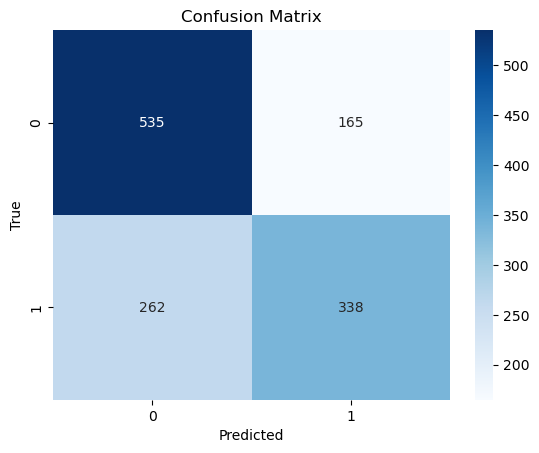

In [527]:
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

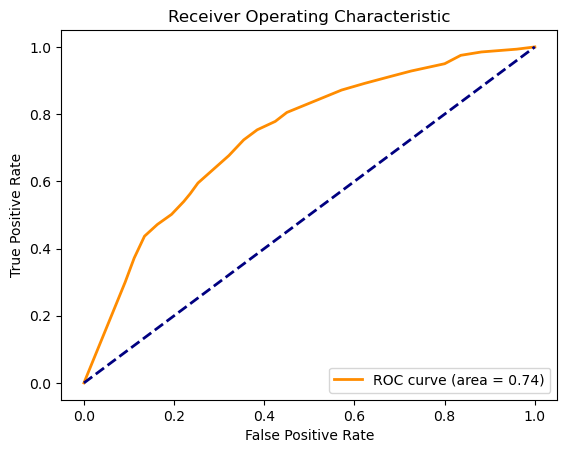

In [528]:
fpr, tpr, thresholds = roc_curve(y_test, best_dt.predict_proba(X_test)[:,1])
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

In [529]:
feature_names = [name.replace('&', '').replace('<', '').replace('>', '').replace(' ', '') for name in X_train.columns]
# feature_names

In [530]:
dot_data = export_graphviz(best_dt, out_file=None,
                           feature_names=feature_names,  
                           class_names=["ROELess12", "ROEGreater12"],  # Adjust class names as necessary
                           filled=True, rounded=True,
                           special_characters=True)

In [531]:
graph = graphviz.Source(dot_data)


In [532]:
graph.render("decision_tree", format='png', cleanup=True)

'decision_tree.png'

## LOGISTIC REGRESSION

In [533]:
y.value_counts(normalize=True)

0    0.551605
1    0.448395
Name: ROE_12%, dtype: float64

In [534]:
l_pipeline = Pipeline([
    ('poly', PolynomialFeatures()),
    ('scaler', StandardScaler()),
    ('classifier', LogisticRegression(solver='liblinear', max_iter=1000))
])

In [535]:
# ran poly degree 1 and 2 and non-linearity did not make a difference.

l_param_grid = {
    'poly__degree': [1],
    'classifier__C': [0.001, 0.01, 0.1, 1, 10, 100, 250],
    'classifier__penalty': ['l2']
}

In [536]:
l_grid_search = GridSearchCV(l_pipeline, l_param_grid, cv=5, scoring='accuracy')

In [537]:
l_grid_search.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('poly', PolynomialFeatures()),
                                       ('scaler', StandardScaler()),
                                       ('classifier',
                                        LogisticRegression(max_iter=1000,
                                                           solver='liblinear'))]),
             param_grid={'classifier__C': [0.001, 0.01, 0.1, 1, 10, 100, 250],
                         'classifier__penalty': ['l2'], 'poly__degree': [1]},
             scoring='accuracy')

In [538]:
print("Best parameters:", l_grid_search.best_params_)
print("Best cross-validation score: {:.2f}".format(l_grid_search.best_score_))
print("Test-set score: {:.2f}".format(l_grid_search.score(X_test, y_test)))

Best parameters: {'classifier__C': 100, 'classifier__penalty': 'l2', 'poly__degree': 1}
Best cross-validation score: 0.90
Test-set score: 0.90


In [539]:
l_best_model = l_grid_search.best_estimator_

In [540]:
l_results = pd.DataFrame(l_grid_search.cv_results_).sort_values('rank_test_score', ascending=True)
l_results.head(5)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_classifier__C,param_classifier__penalty,param_poly__degree,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
5,0.346029,0.059962,0.003529,0.006110,100,l2,1,"{'classifier__C': 100, 'classifier__penalty': ...",0.906096,0.902640,0.899340,0.905941,0.900990,0.903001,0.002676,1
6,0.347762,0.076583,0.003126,0.006251,250,l2,1,"{'classifier__C': 250, 'classifier__penalty': ...",0.909390,0.907591,0.894389,0.904290,0.896040,0.902340,0.006066,2
4,0.184789,0.023768,0.003132,0.006263,10,l2,1,"{'classifier__C': 10, 'classifier__penalty': '...",0.883031,0.896040,0.891089,0.886139,0.882838,0.887827,0.005076,3
3,0.065437,0.014115,0.000000,0.000000,1,l2,1,"{'classifier__C': 1, 'classifier__penalty': 'l...",0.825371,0.843234,0.825083,0.838284,0.820132,0.830421,0.008785,4
2,0.036395,0.010280,0.000000,0.000000,0.1,l2,1,"{'classifier__C': 0.1, 'classifier__penalty': ...",0.761120,0.778878,0.749175,0.760726,0.762376,0.762455,0.009496,5


In [541]:
l_y_pred = l_best_model.predict(X_test)
print('\n',"Classification Report:\n", classification_report(y_test, l_y_pred), '\n')
print("ROC AUC Score:", roc_auc_score(y_test, l_y_pred))


 Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.92      0.91       700
           1       0.90      0.88      0.89       600

    accuracy                           0.90      1300
   macro avg       0.90      0.90      0.90      1300
weighted avg       0.90      0.90      0.90      1300
 

ROC AUC Score: 0.9016666666666667


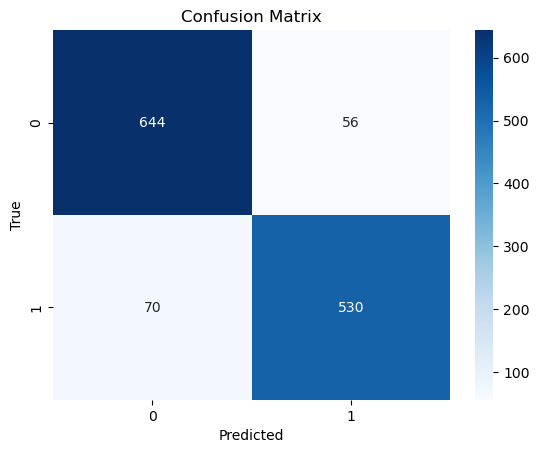

In [542]:
l_cm = confusion_matrix(y_test, l_y_pred)
sns.heatmap(l_cm, annot=True, fmt="d", cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

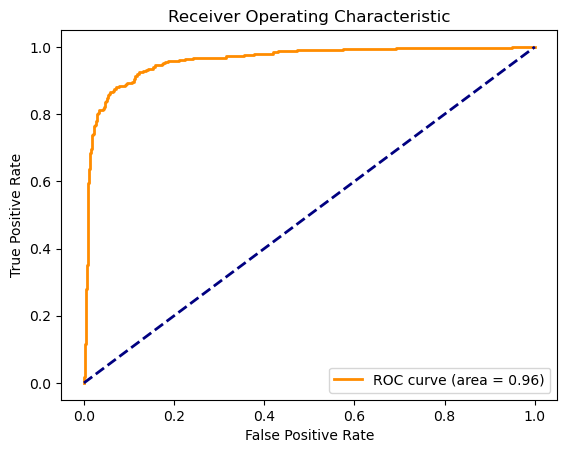

In [543]:
fpr, tpr, thresholds = roc_curve(y_test, l_best_model.predict_proba(X_test)[:,1])
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

In [544]:
l_feature_names = l_best_model.named_steps['poly'].get_feature_names_out(input_features=X_train.columns)
coefficients = l_best_model.named_steps['classifier'].coef_[0] 

In [545]:
feature_importance = pd.DataFrame({
    'Feature': l_feature_names,
    'Coefficient': coefficients
})

# Sorting the features by the absolute values of their coefficients in descending order
feature_importance['Absolute Coefficient'] = feature_importance['Coefficient'].abs()
feature_importance = feature_importance.sort_values(by='Absolute Coefficient', ascending=False)
feature_importance.head(15)

,Feature,Coefficient,Absolute Coefficient
40,remainder__NII: Fiduciary Activities/ Avg Asse...,70.605964,70.605964
58,remainder__Other Noninterest Exp/ Avg Assets (%),-57.155630,57.155630
55,remainder__Salary Expense/ Avg Assets (%),-25.798818,25.798818
17,remainder__Asset-weighted Loan Yield (%),11.531850,11.531850
54,remainder__NII: Other Noninterest Inc/ Avg Ass...,11.073750,11.073750
...,...,...,...
18,remainder__Asset-weighted Securities Yield (%),3.305672,3.305672
37,remainder__Avg Int-bear Deps/ Avg Int-bear Lia...,-3.298624,3.298624
7,remainder__Provision Expense/ Avg Assets (%),-3.007206,3.007206
44,remainder__Gain on Asset Sales/ Avg Assets (%),2.929263,2.929263


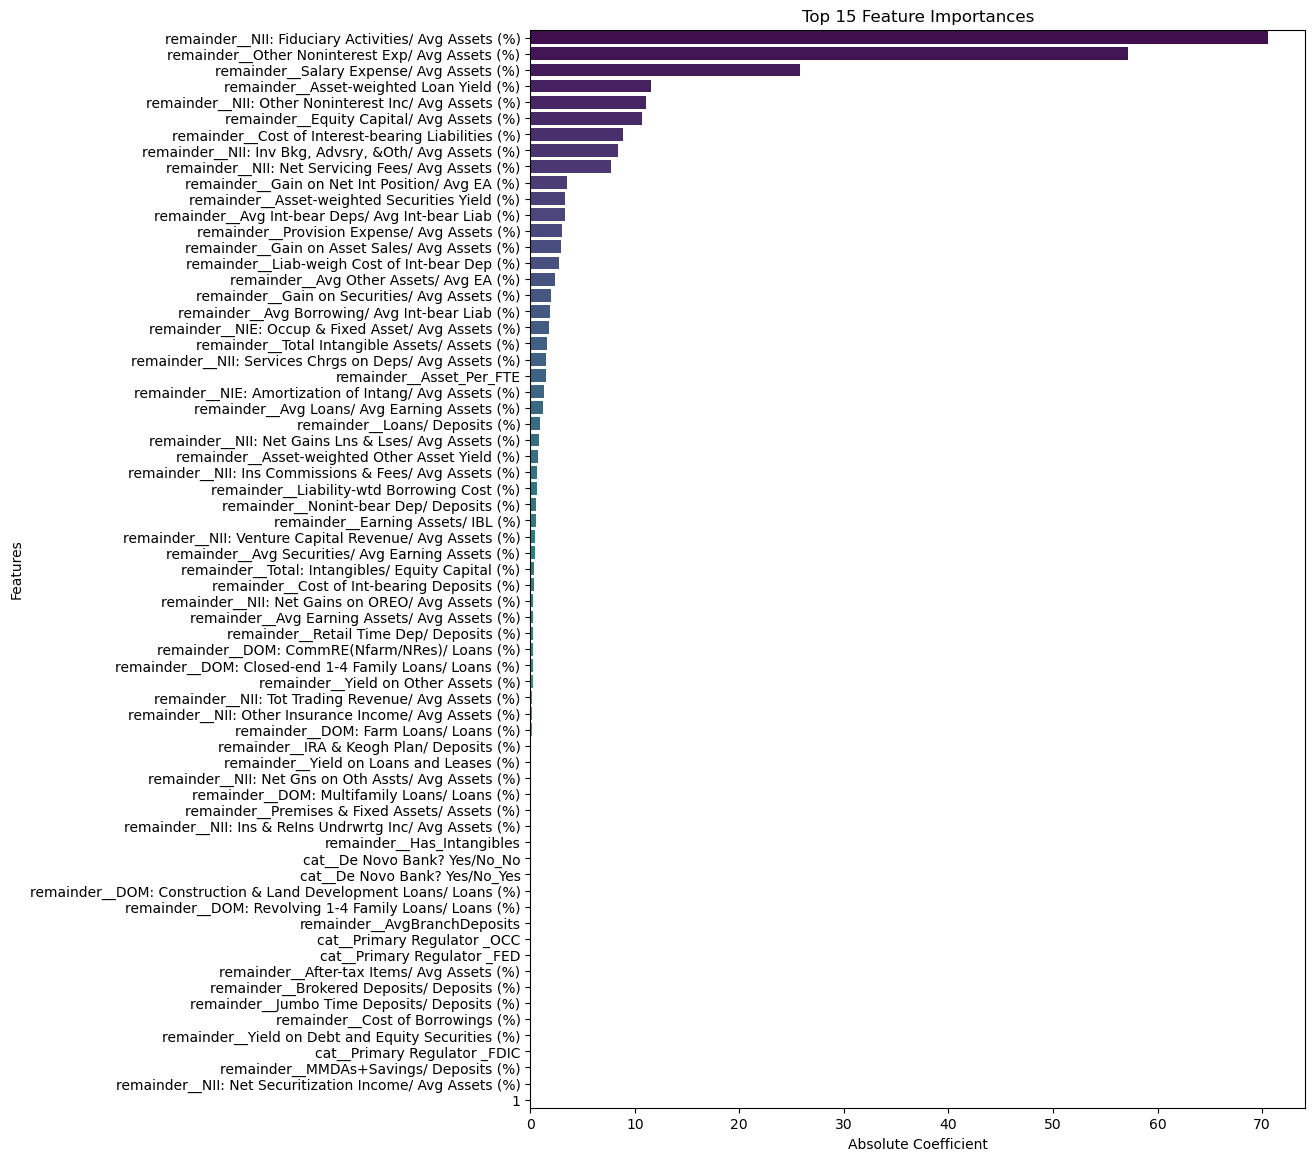

In [548]:
plt.figure(figsize=(10, 14))
sns.barplot(x='Absolute Coefficient', y='Feature', data=feature_importance, palette='viridis')
plt.title('Top 15 Feature Importances')
plt.xlabel('Absolute Coefficient')
plt.ylabel('Features')

plt.show()